# Modeling

In [44]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score ,roc_curve,auc,f1_score, precision_recall_curve

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt

In [45]:
df = pd.read_csv('winequality-red-scaled2.csv')

In [46]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.526823,0.967437,-1.396766,-0.468591,-0.286544,-0.472221,-0.389808,0.602517,1.336203,-0.586360,1,0
1,-0.295502,1.980100,-1.396766,-0.085050,0.023186,0.885977,0.615217,0.052556,-0.727179,0.108276,1,0
2,-0.295502,1.304992,-1.191446,-0.249425,-0.061286,-0.084165,0.219298,0.162548,-0.327815,-0.065383,1,0
3,1.670732,-1.395443,1.477714,-0.468591,-0.300623,0.109864,0.402030,0.712509,-0.993422,-0.470587,1,0
4,-0.526823,0.742401,-1.396766,-0.523383,-0.300623,-0.278193,-0.207076,0.602517,1.336203,-0.586360,1,0


In [47]:
df['alcohol'].value_counts()

1    637
2    594
0    128
Name: alcohol, dtype: int64

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1359 non-null   float64
 3   residual sugar        1359 non-null   float64
 4   chlorides             1359 non-null   float64
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   int64  
 11  quality               1359 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 127.5 KB


In [49]:
#from sklearn.preprocessing import LabelEncoder
#labelencoder_y = LabelEncoder()
#df['quality'] = labelencoder_y.fit_transform(df['quality'])

# Train Test Split

In [50]:
X = df.drop('quality', axis = 1).values
y = df['quality'].values.reshape(-1,1)

In [58]:
from sklearn.model_selection import train_test_split
X_train0, X_test, y_train0, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (1218, 11)
Shape of X_test:  (272, 11)
Shape of y_train:  (1218,)
Shape of y_test (272, 1)


In [60]:
pd.DataFrame(y_train0).value_counts()

0    937
1    150
dtype: int64

# SMOTE for Balancing Data

In [81]:
oversample = SMOTE(sampling_strategy=0.5, random_state=42)
X_train, y_train = oversample.fit_resample(X_train0, y_train0)

In [82]:
oversample.get_params()

{'k_neighbors': 5,
 'n_jobs': None,
 'random_state': 42,
 'sampling_strategy': 0.5}

In [83]:
from collections import Counter
print(Counter(y_train))

Counter({0: 937, 1: 468})


# 1. Logistic Regression

In [124]:
from sklearn.linear_model import LogisticRegression
classifier_lr = LogisticRegression(C=1, fit_intercept=True, max_iter=1000, penalty = 'l2',solver='liblinear')
classifier_lr.fit(X_train, y_train.ravel())

LogisticRegression(C=1, max_iter=1000, solver='liblinear')

In [125]:
# Predicting Cross Validation Score

cv_lr = cross_val_score(estimator = classifier_lr, X = X_train, y = y_train.ravel(), cv = 5)
print("CV: ", cv_lr.mean())

y_pred_lr_train = classifier_lr.predict(X_train)
accuracy_lr_train = accuracy_score(y_train, y_pred_lr_train)
print("Training set: ", accuracy_lr_train)

y_pred_lr_test = classifier_lr.predict(X_test)
accuracy_lr_test = accuracy_score(y_test, y_pred_lr_test)
print("Test set: ", accuracy_lr_test)

CV:  0.8128113879003559
Training set:  0.8170818505338078
Test set:  0.8566176470588235


In [126]:
confusion_matrix(y_test, y_pred_lr_test)

array([[208,  30],
       [  9,  25]], dtype=int64)

# 2. Random Forest Classification

In [173]:
rf_params = {'n_estimators' : [200,400,600,800,1000],
             'random_state' : range(39,50),
             'bootstrap': [True, False],
             'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10]}

In [177]:
from sklearn.ensemble import RandomForestClassifier
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = rf_params, n_iter = 100, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.2min finished


RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000],
                                        'random_state': range(39, 50)},
                   verbose=2)

In [178]:
rf_random.best_params_

{'random_state': 48,
 'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': False}

In [189]:
rf_params = {'n_estimators' : [500,550,600],
             'class_weight' : ['balanced'],
             'random_state' : range(39,50),
             'criterion' : ['entropy'],
             'bootstrap': [False],
             'max_depth': [12, 15, 18, 20],
             'max_features': ['auto'],
             'min_samples_leaf': [1],
             'min_samples_split': [2]}

In [190]:
from sklearn.ensemble import RandomForestClassifier
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = rf_params, n_iter = 100, verbose=2, n_jobs = 7)
# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
C:\Users\Anshu\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   11.1s
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed:   50.3s
[Parallel(n_jobs=7)]: Done 351 tasks      | elapsed:  2.0min
[Parallel(n_jobs=7)]: Done 500 out of 500 | elapsed:  2.5min finished


RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=100, n_jobs=7,
                   param_distributions={'bootstrap': [False],
                                        'class_weight': ['balanced'],
                                        'criterion': ['entropy'],
                                        'max_depth': [10, 12, 15, 18, 20],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [1, 2],
                                        'n_estimators': [450, 500, 550, 600],
                                        'random_state': range(39, 50)},
                   verbose=2)

In [191]:
rf_random.best_params_

{'random_state': 41,
 'n_estimators': 550,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'criterion': 'entropy',
 'class_weight': 'balanced',
 'bootstrap': False}

In [162]:
cv_rf = cross_val_score(estimator = classifier_rf, X = X_train, y = y_train.ravel(), cv = 10)
print("CV: ", cv_rf.mean())

CV:  0.9167983789260384


In [196]:
rf_random = RandomForestClassifier(**{'random_state': 41,
 'n_estimators': 550,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'criterion': 'entropy',
 'class_weight': 'balanced',
 'bootstrap': False})

rf_random.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=20, n_estimators=550,
                       random_state=41)

In [197]:
y_pred_rf_train = rf_random.predict(X_train)
accuracy_rf_train = accuracy_score(y_train, y_pred_rf_train)
print("Training set: ", accuracy_rf_train)

y_pred_rf_test = rf_random.predict(X_test)
accuracy_rf_test = accuracy_score(y_test, y_pred_rf_test)
print("Test set: ", accuracy_rf_test)

Training set:  1.0
Test set:  0.8860294117647058


In [198]:
print("Training set accuracy : {}\nConfusion matrix :\n {}\nFull Report :\n{}\nroc_auc_score : {}".format(accuracy_score(y_pred_rf_test,y_test),confusion_matrix(y_pred_rf_test,y_test),classification_report(y_pred_rf_test,y_test),roc_auc_score(y_pred_rf_test,y_test)))

Training set accuracy : 0.8860294117647058
Confusion matrix :
 [[226  19]
 [ 12  15]]
Full Report :
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       245
           1       0.44      0.56      0.49        27

    accuracy                           0.89       272
   macro avg       0.70      0.74      0.71       272
weighted avg       0.90      0.89      0.89       272

roc_auc_score : 0.7390022675736961


# 3. Xgboost Classifier

In [64]:
# ! pip3 install xgboost

In [84]:
import xgboost as xgb

In [85]:
wine_dmatrix = xgb.DMatrix(data=X_train,label=y_train.ravel())

In [107]:
gbm_param_grid = {'learning_rate': [0.05,0.1,0.15,0.20,0.25],
'max_depth': [3,4,5,6,8,10,12,15],
'min_child_weight':[1,3,5,7],
'gamma':[0.0,0.1,0.2,0.3,0.4],
'colsample_bytree':[0.3,0.4,0.5,0.7],
'n_estimators':[100,200,300],
'random_state':range(39,50)}

In [108]:
gbm = xgb.XGBClassifier(use_label_encoder=False)

In [109]:
grid_mse = RandomizedSearchCV(gbm,param_distributions=gbm_param_grid,n_iter=5,scoring='roc_auc',n_jobs=-1, cv=5, verbose=3)
grid_mse.fit(X, y)
print("Best parameters found: ",grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    6.5s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    6.7s finished


[01:28:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters found:  {'random_state': 41, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.3}
Lowest RMSE found:  0.9314097486415661


In [155]:
gbm_best = xgb.XGBClassifier(**grid_mse.best_params_, use_label_encoder=False)

In [156]:
gbm_best.fit(X_train,y_train)

[01:45:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=41,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [157]:
gbm_best.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.3,
 'gamma': 0.4,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.05,
 'max_delta_step': 0,
 'max_depth': 8,
 'min_child_weight': 5,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 41,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [113]:
y_pred_xgb = gbm_best.predict(X_test)

In [114]:
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.07%


In [115]:
confusion_matrix(y_test, y_pred_xgb)

array([[223,  15],
       [ 12,  22]], dtype=int64)

In [116]:
print("Training set accuracy : {}\nConfusion matrix :\n {}\nFull Report :\n{}\nroc_auc_score : {}".format(accuracy_score(y_pred_xgb,y_test),confusion_matrix(y_pred_xgb,y_test),classification_report(y_pred_xgb,y_test),roc_auc_score(y_pred_xgb,y_test)))

Training set accuracy : 0.9007352941176471
Confusion matrix :
 [[223  12]
 [ 15  22]]
Full Report :
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       235
           1       0.65      0.59      0.62        37

    accuracy                           0.90       272
   macro avg       0.79      0.77      0.78       272
weighted avg       0.90      0.90      0.90       272

roc_auc_score : 0.7717653824036804


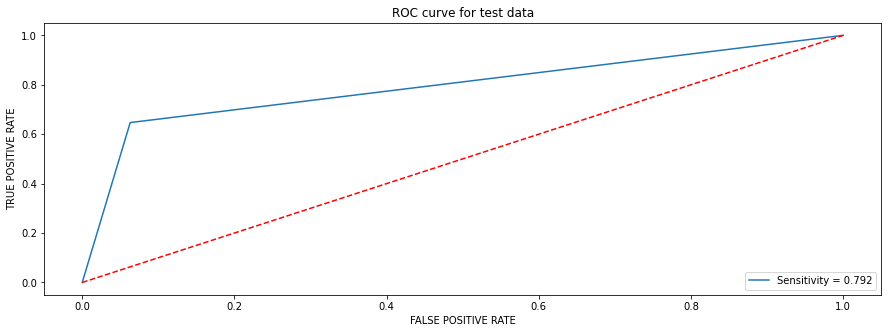

In [117]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred_xgb)
roc_auc = roc_auc_score(y_test,y_pred_xgb)
plt.figure(figsize  = (15,5))
plt.plot(fpr, tpr, label = 'Sensitivity = %0.3f'% roc_auc )
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('FALSE POSITIVE RATE')
plt.ylabel('TRUE POSITIVE RATE')
plt.title('ROC curve for test data')
plt.legend(loc="lower right")
plt.show()

No Skill: ROC AUC=0.500
XGBOOST: ROC AUC=0.883


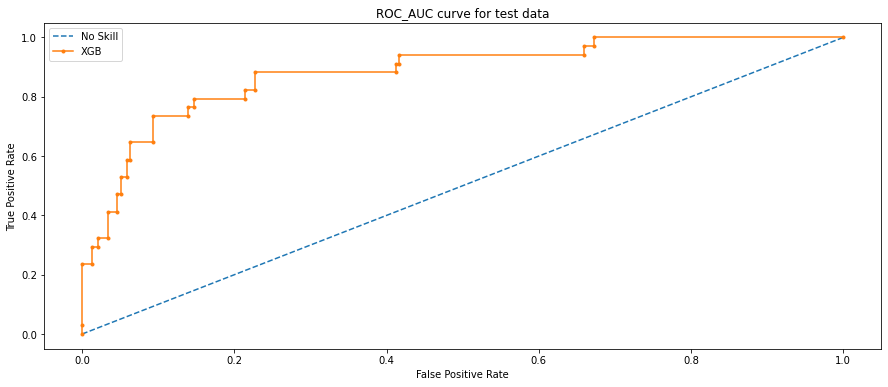

In [118]:
########### ROC  AUC curve   ######
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = gbm_best.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBOOST: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
plt.figure(figsize = (15,6))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='XGB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title("ROC_AUC curve for test data")
plt.show()  

XGBOOST: f1=0.620 auc=0.616


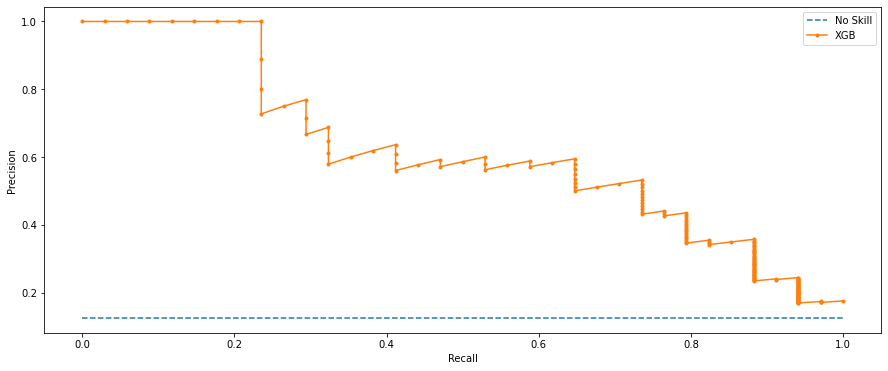

In [119]:
# Precision Recall curve
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred_xgb), auc(lr_recall, lr_precision)
no_skill = len(y_test[y_test==1]) / len(y_test)
# summarize scores
print('XGBOOST: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
plt.figure(figsize=(15,6))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='XGB')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Ensembling

In [158]:
from sklearn.ensemble import VotingClassifier

In [159]:
#create a dictionary of our models
estimators=[("log_reg",classifier_lr), ("rf",classifier_rf), ("xgb_best",gbm_best)]

In [160]:
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting="soft")

In [161]:
#fit model to training data
ensemble.fit(X_train, y_train)
y_ensemble = ensemble.predict(X_test)

[01:46:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
#test our model on the test data
ensemble.score(X_test, y_test)

In [149]:
confusion_matrix(y_ensemble, y_test)

array([[217,  10],
       [ 21,  24]], dtype=int64)

In [148]:
print("Training set accuracy : {}\nConfusion matrix :\n {}\nFull Report :\n{}\nroc_auc_score : {}".format(accuracy_score(y_ensemble,y_test),confusion_matrix(y_ensemble,y_test),classification_report(y_ensemble,y_test),roc_auc_score(y_ensemble,y_test)))

Training set accuracy : 0.8860294117647058
Confusion matrix :
 [[217  10]
 [ 21  24]]
Full Report :
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       227
           1       0.71      0.53      0.61        45

    accuracy                           0.89       272
   macro avg       0.81      0.74      0.77       272
weighted avg       0.88      0.89      0.88       272

roc_auc_score : 0.7446402349486049
